# Step by Step guide for a basic DeepAR model

In [1]:
import os
os.chdir("/home/reffert/DeepAR_InfluenzaForecast")

## 1. Imports & CSV-Reading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator
from gluonts.dataset.util import to_pandas
from gluonts.dataset import common
from gluonts.evaluation import make_evaluation_predictions
from PythonFiles.Configuration import Configuration

config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')
df.head()

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


,Unnamed: 0,year,date,week,age_group,location,value
0,0,2002,2002-01-06,1,00+,LK Alb-Donau-Kreis,0.0
1,1,2002,2002-01-13,2,00+,LK Alb-Donau-Kreis,0.0
2,2,2002,2002-01-20,3,00+,LK Alb-Donau-Kreis,0.0
3,3,2002,2002-01-27,4,00+,LK Alb-Donau-Kreis,0.0
4,4,2002,2002-02-03,5,00+,LK Alb-Donau-Kreis,0.0


## 2. Data Processing

In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
correctly_spaced_index = pd.date_range(start=config.train_start_time,
                                       end=config.test_end_time,
                                       freq=config.freq)

correctly_spaced_location_df = pd.DataFrame(index=correctly_spaced_index)
correctly_spaced_df = pd.DataFrame()
location_list = df.loc[:, 'location'].unique()
for location in location_list:
    temporary_df = correctly_spaced_location_df.join(df.loc[df.location == location])
    temporary_df['location'] = temporary_df['location'].fillna(location)
    temporary_df['age_group'] = temporary_df['age_group'].fillna("00+")
    correctly_spaced_df = pd.concat([correctly_spaced_df, temporary_df])

## 3. Data Splitting

In [4]:
df = correctly_spaced_df.copy()
start = df.loc[(df.index>=config.train_start_time)].index[0]
training_data = common.ListDataset(
            [{"start": start, "target": df.loc[(df.index >= config.train_start_time) & 
                                               (df.index <= config.train_end_time) & 
                                               (df.location == location), config.target]}
             for location in df.loc[:, 'location'].unique()], freq=config.freq)

test_data = common.ListDataset(
            [{"start": start, "target": df.loc[(df.index <= config.test_end_time) & 
                                               (df.index >= config.train_start_time) & 
                                               (df.location == location), config.target]}
             for location in df.loc[: , 'location'].unique()], freq=config.freq)

## 4. Estimator training and Prediction

In [5]:
estimator = DeepAREstimator(freq=config.freq,
                            context_length=config.context_length,
                            prediction_length=104,
                            num_layers=config.num_layers,
                            num_cells=config.num_cells,
                            cell_type=config.cell_type,
                            trainer=config.trainer,
                            distr_output=config.distr_output,
                           )

# train the estimator
predictor = estimator.train(training_data=training_data)

forecast_it, ts_it = make_evaluation_predictions(dataset=test_data,  
                                                 predictor=predictor,  
                                                 num_samples=100,  
                                                 )
forecasts = list(forecast_it)
tss = list(ts_it)

100%|██████████| 50/50 [00:15<00:00,  3.26it/s, epoch=4/4, avg_epoch_loss=0.816]


## 5. Plotting of selected time series

SK Speyer


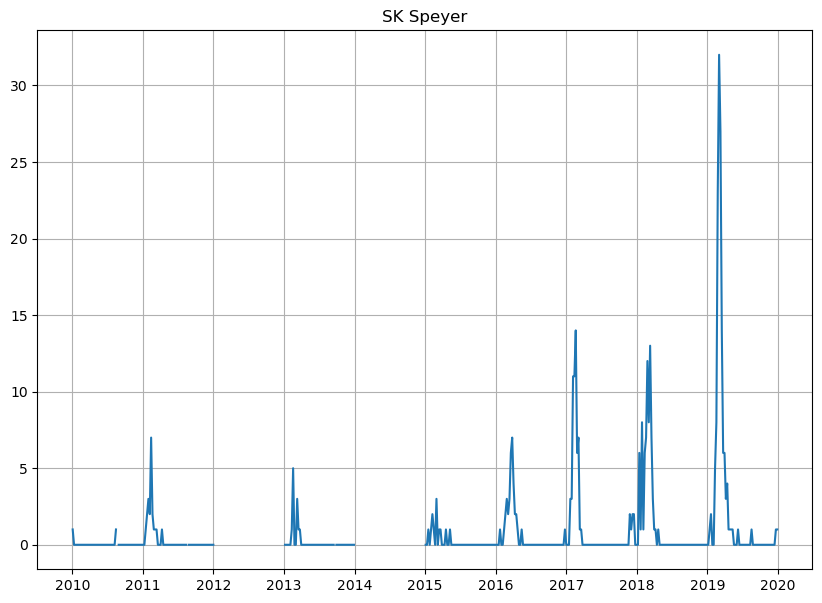

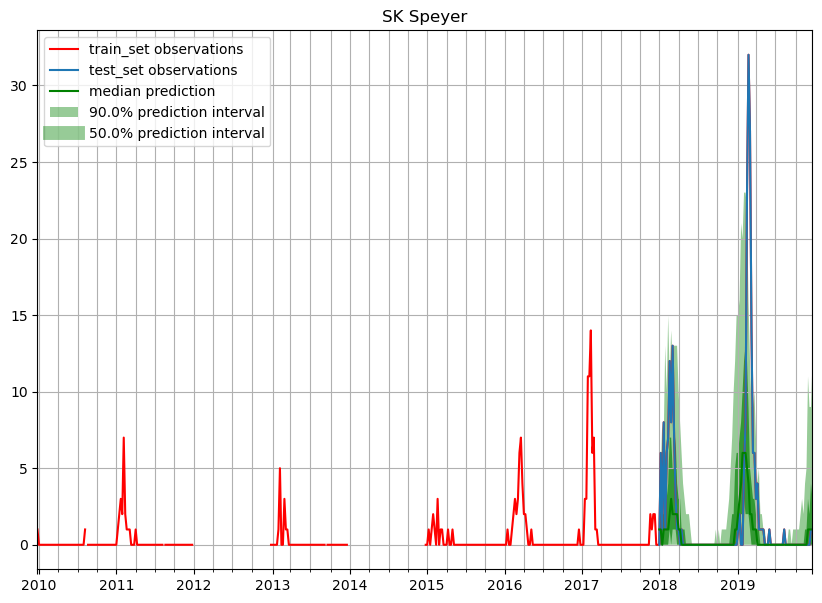

LK Bad Dürkheim


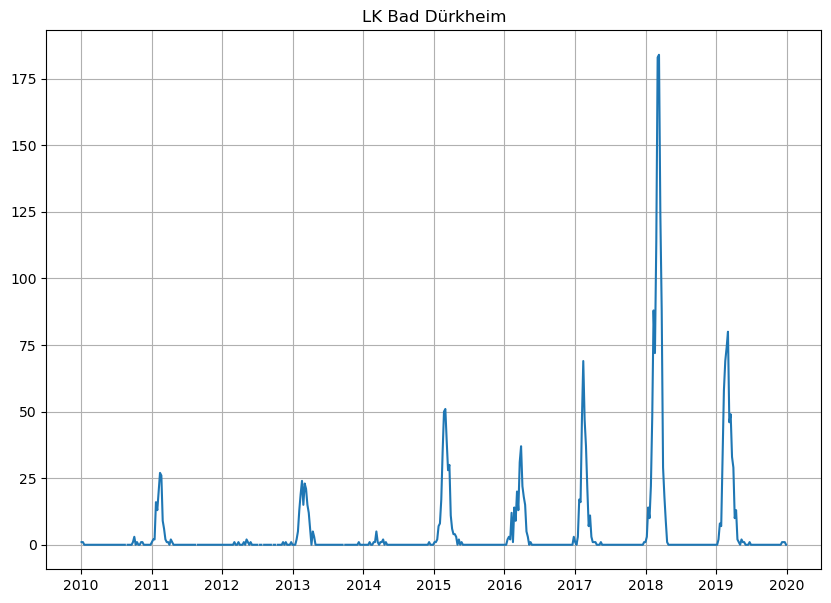

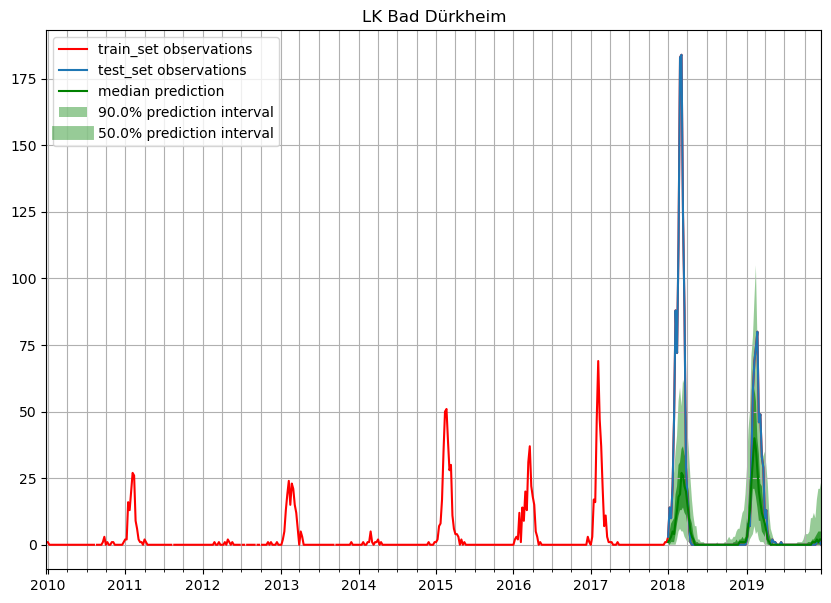

In [6]:
def plot_prob_forecasts(ts_entry, forecast_entry, test_data, title=""):
    plot_length = 104
    prediction_intervals = (50.0, 90.0)
    legend = ["train_set observations", "test_set observations", "median prediction"] \
             + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    to_pandas(test_data).to_timestamp().plot(color="r")
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.title(title)
    plt.legend(legend, loc="upper left")
    plt.show()

locations = [location for location in df.loc[:, 'location'].unique()]
selected_regions = ["SK Speyer", "LK Bad Dürkheim"]
for k in [locations.index(location) for location in selected_regions]:
    ts_entry = tss[k]
    forecast_entry = forecasts[k]
    print(locations[k])
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{locations[k]}')
    # Plot the true values once seperately
    plt.plot((df.loc[(df['location'] == str(locations[k])) & 
                     (df.index <= config.test_end_time) & 
                     (df.index >= config.train_start_time)].index),
             df.loc[(df['location'] == str(locations[k])) &
                    (df.index <= config.test_end_time) &
                    (df.index >= config.train_start_time),'value'])
    plt.grid(which="both")
    plt.show()
    plot_prob_forecasts(ts_entry, forecast_entry, test_data[k], title=f'{locations[k]}')